In [2]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

few_shot_files = sorted(glob("../data/test*pred.csv"))
one_shot_files = sorted(glob("../data/test*pred*1shot.csv"))
beto_files = sorted(glob("../data/test*beto.csv"))

assert len(few_shot_files) == len(one_shot_files) == len(beto_files)

dfs = {
    "one-shot": pd.concat([pd.read_csv(f, index_col=0) for f in one_shot_files]),
    "few-shot": pd.concat([pd.read_csv(f, index_col=0) for f in few_shot_files]),
    "beto": pd.concat([pd.read_csv(f, index_col=0) for f in beto_files]),
}


In [3]:
assert all(dfs["few-shot"].index == dfs["one-shot"].index)
assert all(dfs["few-shot"].index == dfs["beto"].index)

## Error analysis

In [4]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]

dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [5]:
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]
pred_labels = [f"PRED_{label}" for label in labels]

In [6]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


one-shot


  0%|          | 0/4 [00:00<?, ?it/s]

few-shot


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,one-shot,WOMEN,recall,0.283871
1,one-shot,WOMEN,recall,0.301471
2,one-shot,WOMEN,recall,0.278689
3,one-shot,WOMEN,recall,0.301587
4,one-shot,WOMEN,recall,0.309859
...,...,...,...,...
35995,beto,CLASS,f1,0.573529
35996,beto,CLASS,f1,0.614035
35997,beto,CLASS,f1,0.627737
35998,beto,CLASS,f1,0.611940


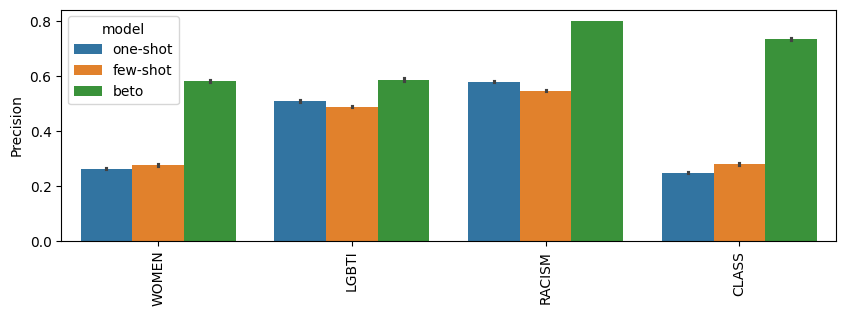

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "precision"

plt.figure(figsize=(10, 3))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.xlabel('')
plt.ylabel(metric.capitalize())

# Show the plot

plt.xticks(rotation=90)
#plt.show()

plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

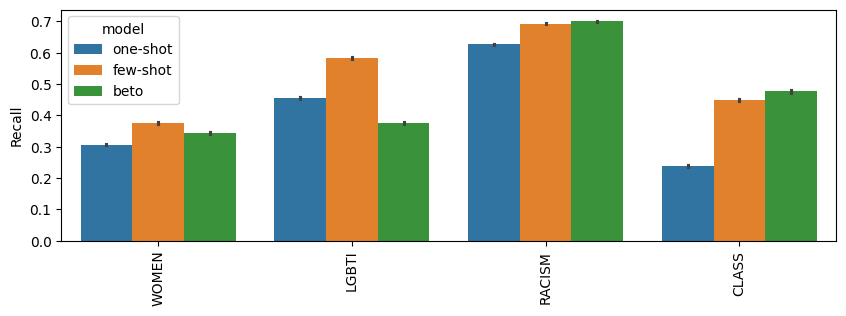

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

metric = "recall"

plt.figure(figsize=(10, 3))
sns.barplot(x='label', y='score', hue='model', data=df_metrics[df_metrics["metric"] == metric], hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.xlabel('')
plt.ylabel(metric.capitalize())

# Show the plot

plt.xticks(rotation=90)
#plt.show()
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

In [32]:
# Just keep the most important characteristics

hate_metrics = []


for name, df in dfs.items():
    label_hate = df[labels].sum(axis=1) > 0
    pred_hate = df[pred_labels].sum(axis=1) > 0

    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,one-shot,recall,0.540881
1,one-shot,recall,0.522267
2,one-shot,recall,0.484407
3,one-shot,recall,0.516556
4,one-shot,recall,0.513238
...,...,...,...
8995,beto,f1,0.618705
8996,beto,f1,0.634921
8997,beto,f1,0.638398
8998,beto,f1,0.638498


([0, 1, 2], [Text(0, 0, 'recall'), Text(1, 0, 'precision'), Text(2, 0, 'f1')])

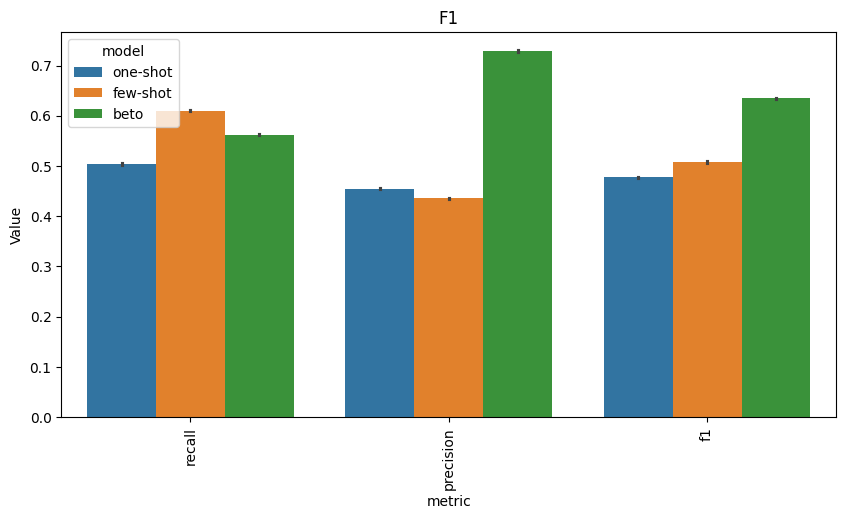

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=["one-shot", "few-shot", "beto"])


# Set the plot title and labels
plt.title(metric.capitalize())
plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [41]:

# Show as mean +/- std
res = hate_metrics.groupby(["model", "metric"]).mean().round(3).astype(str) + " \pm " + hate_metrics.groupby(["model", "metric"]).std().round(3).astype(str)

print(res.to_latex())

\begin{tabular}{lll}
\toprule
 &  & score \\
model & metric &  \\
\midrule
\multirow[t]{3}{*}{beto} & f1 & 0.635 \pm 0.019 \\
 & precision & 0.729 \pm 0.023 \\
 & recall & 0.562 \pm 0.021 \\
\cline{1-3}
\multirow[t]{3}{*}{few-shot} & f1 & 0.508 \pm 0.018 \\
 & precision & 0.435 \pm 0.019 \\
 & recall & 0.61 \pm 0.022 \\
\cline{1-3}
\multirow[t]{3}{*}{one-shot} & f1 & 0.478 \pm 0.019 \\
 & precision & 0.455 \pm 0.021 \\
 & recall & 0.504 \pm 0.022 \\
\cline{1-3}
\bottomrule
\end{tabular}

